In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import preliz as pz
import pymc as pm
from scipy.special import expit as logistic


In [2]:
az.style.use('arviz-doc')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

##### <center><img src="img/logo_inst.png" width="750">
<br>
<br>
<br>
<br>
<h1 align="center">Modelos Jerárquicos</h1>    


<br>
<br>
<br>
<br>
<br>

## Objetivos

* Aprender a construir modelos jerárquicos
* Discutir el concepto de contracción y regularización
* Discutir las implicaciones de agrupar parcialmente los datos

## Modelos Jerárquicos


* Una situación común en estadística se da cuando tenemos varias unidades o grupos similares que queremos analizar
    
* Las dos estrategias más comunes son
    * estudiar cada grupo por separado
    * unificar los grupos en uno solo

## Agrupamiento parcial

<br>

<center><img src="img/pooling.png" width="300"></center>

## Hiper-priors

* Podemos lograr agrupamiento parcial asumiendo que uno (o más) parámetros vienen de una (o más) distribuciones comunes, o hiper-priors

<center><img src="img/hierarchical_model.png" width="500"></center>


## Corrimientos químicos jerárquicos 

<br>

* Las [proteínas](https://www.youtube.com/watch?v=wvTv8TqWC48) son biomoléculas formadas por 20 unidades, llamadas amino ácidos.
* Cada amino ácido puede aparecer en una proteína 0 o más veces.
* Para cada una de estas unidades podemos medir un "corrimiento químico" y también podemos calcularlo usando métodos de Química Cuántica
* Como cada una de las 20 unidades son químicamente diferentes, existe variabilidad entre unidades
* Como el entorno químico (la proteína) modula el valor de un corrimiento químico, existe variabilidad dentro de cada unidad

In [5]:
cs_data = pd.read_csv('../datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
cs_data.tail()

,ID,aa,theo,exp
1771,1KS9,LYS,55.79,57.51
1772,1KS9,ARG,58.91,59.02
1773,1KS9,LYS,59.49,58.92
1774,1KS9,GLU,59.48,58.36
1775,1KS9,SER,58.07,60.55


In [6]:
coords = {"aa": cat_encode.categories}

with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=1, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 
     
    idata_cs_nh = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [7]:
with pm.Model(coords=coords) as cs_h:
    # hyper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=1)
    μ_sd = pm.HalfNormal('μ_sd', 1)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=1, dims="aa") 

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 

    idata_cs_h = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_mu, μ_sd, μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


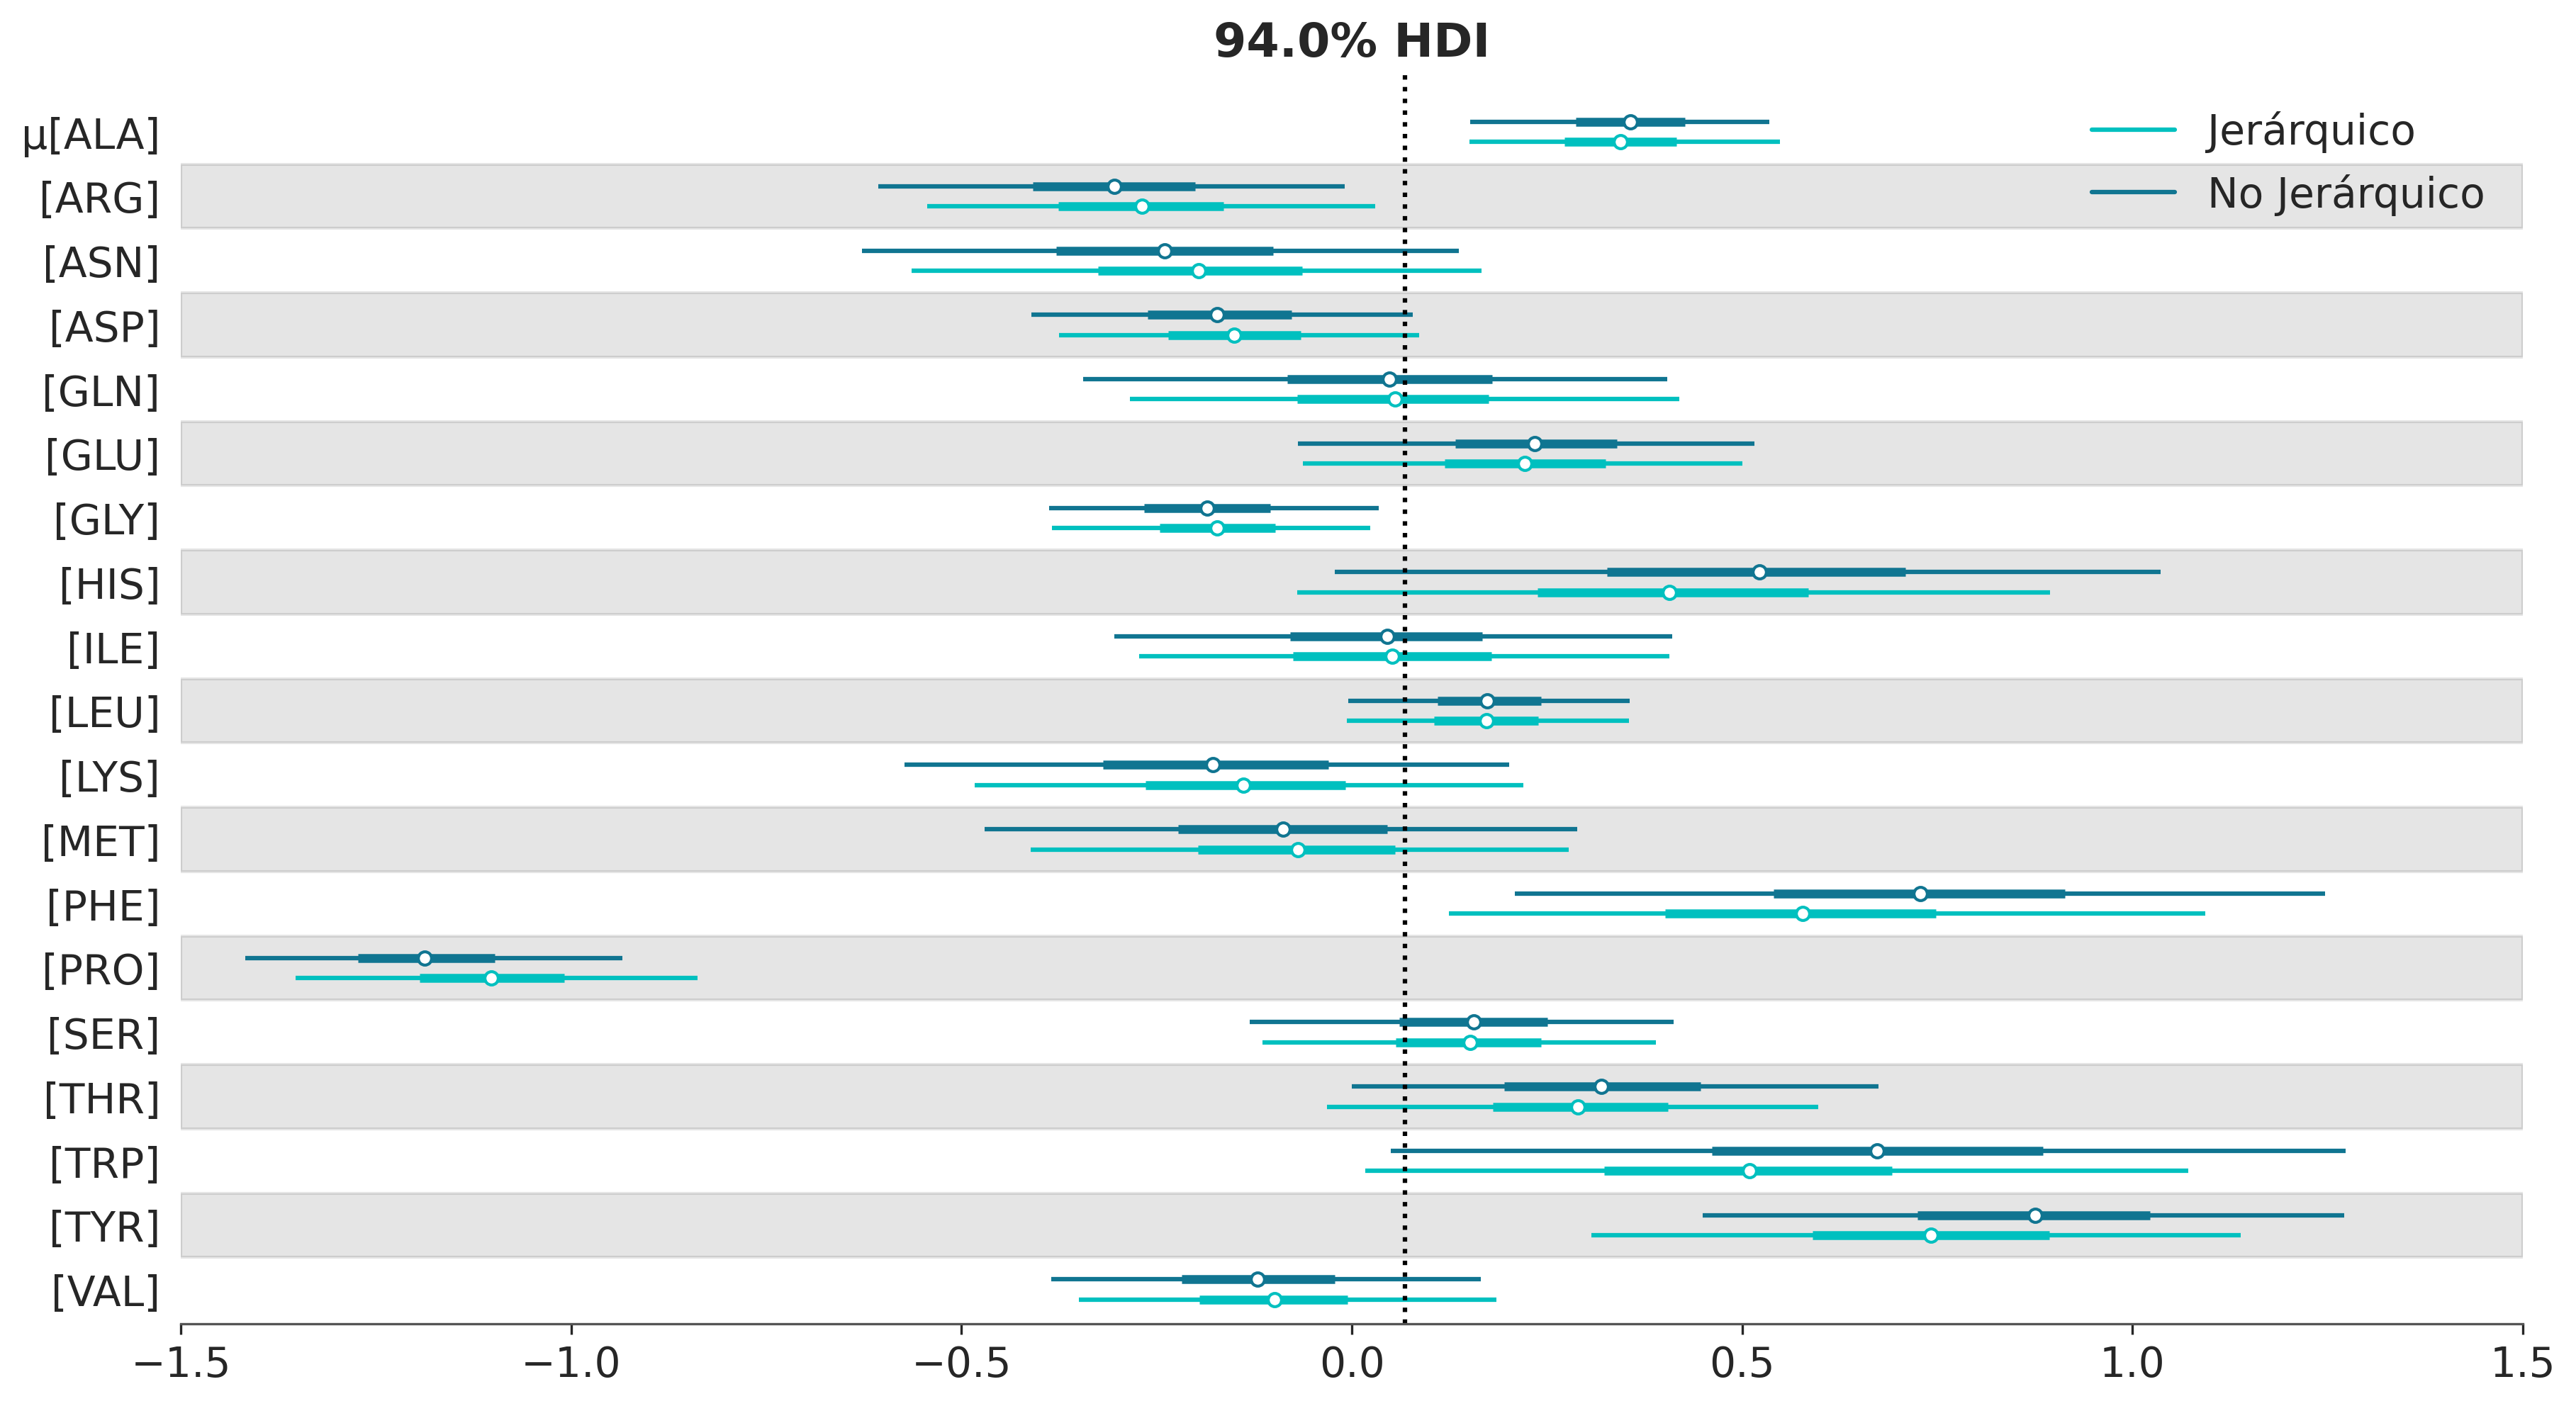

In [8]:
axes = az.plot_forest([idata_cs_nh, idata_cs_h], model_names=['No Jerárquico', 'Jerárquico'],
                      var_names='μ', combined=True, r_hat=False, ess=False, figsize=(12, 6.5),
                      colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":")
axes[0].set_xlim(-1.5, 1.5);

## Contracción y ventajas de los modelos jerárquicos

<br>


* Cada grupo informa a los demás y es informado por los demás.


* La estimación de cada grupo se contrae hacia la media común


* La fuerza de la contracción no es la misma para todos los grupos
     * Los grupos típicos están menos afectados.
     * Los grupos con muestras de mayor tamaño se ven menos afectados.


* Conservar la variación a nivel de grupo y entre grupos


* El modelo jerárquico es una forma de regularización.

## Renacuajos multinivel

<br>

* Tenemos 48 tanques llenos de renacuajos

* Queremos modelar la probabilidad de supervivencia

* Las condiciones como la temperatura, el pH, la luz, etc. varían ligeramente entre los tanques (pero no los estamos teniendo en cuenta explícitamente)

* Podemos pensar en cada tanque como un grupo


<br>


[statistical rethinking](https://xcelab.net/rm/statistical-rethinking/)

In [9]:
d = pd.read_csv('../datos/reedfrogs.csv', sep=",")
d.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [10]:
with pm.Model() as modelo_renacuajos:
    # Hiperpriors
    μ = pm.Normal('μ', 0., 1.)
    σ = pm.HalfNormal('σ', 10.)
    # Prior
    α_tanque = pm.Normal('α_tanque', μ, σ, shape=d.shape[0])
    p = pm.Deterministic('p', pm.math.sigmoid(α_tanque))  # transformación logística
    #likelihood
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    
    idata_renacuajos = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, α_tanque]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


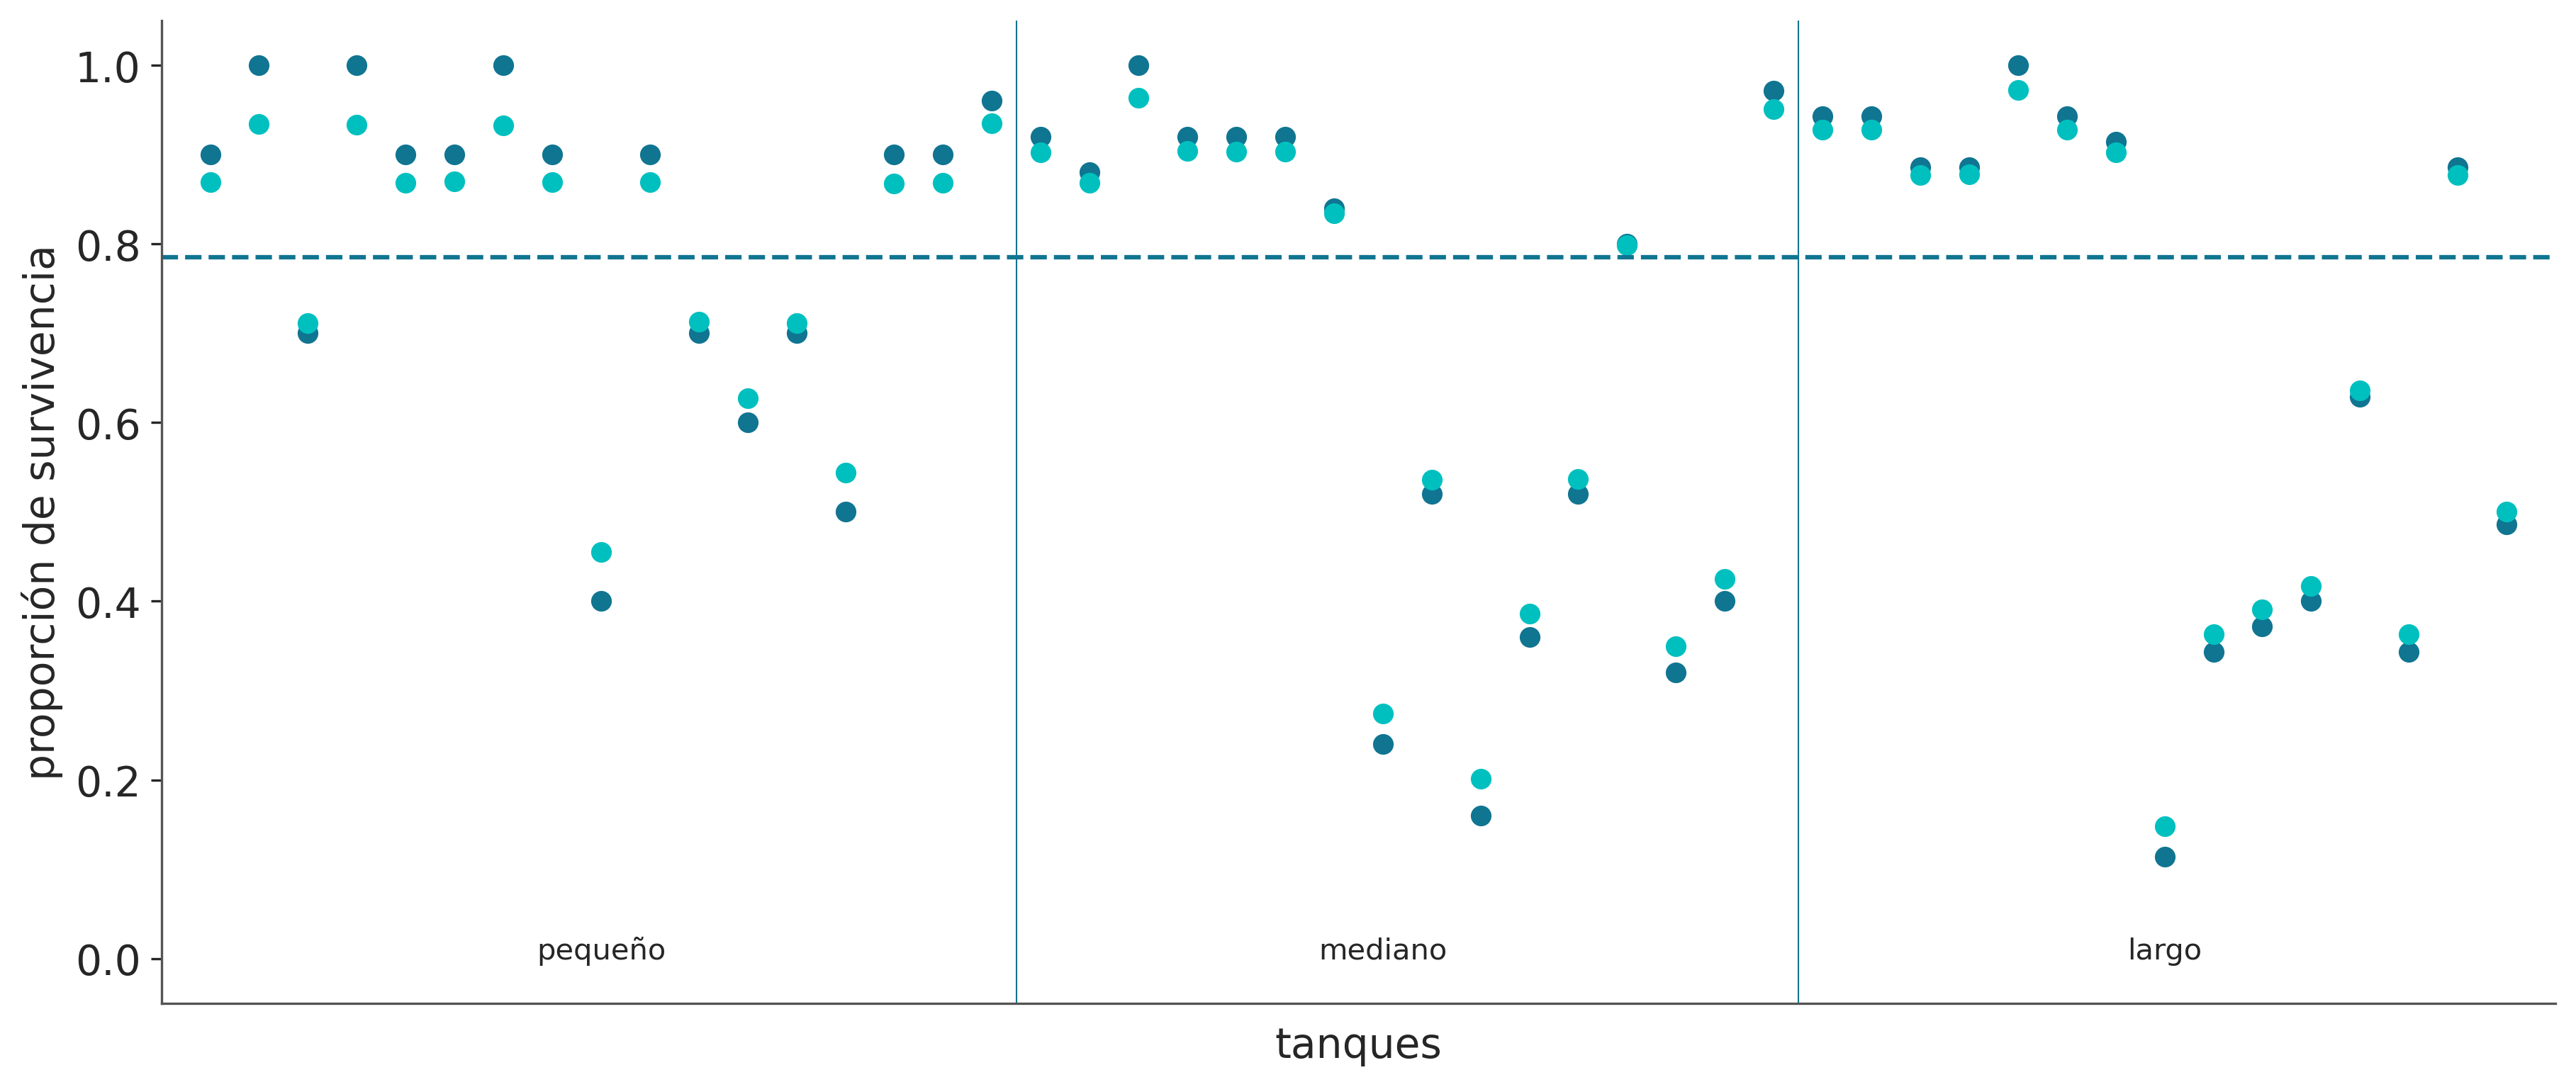

In [11]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))

post_r = az.extract(idata_renacuajos)

ax.scatter(np.arange(0, 48), d.propsurv, color='C0')
ax.scatter(np.arange(0, 48), post_r['p'].mean("sample"), color='C1')
ax.hlines(logistic(post_r['μ'].median("sample")), -1, 49, linestyles='--')

idx = d.density[d.density.diff() > 0].index
ax.vlines(idx + 0.5, -.05, 1.05, lw=.5)
for i, t in zip(np.linspace(0, 48, 7)[1::2], ('pequeño', 'mediano', 'largo')):
    ax.text(i, 0, t, horizontalalignment='center')
ax.set_xlabel('tanques')
ax.set_ylabel('proporción de survivencia')
ax.set_xlim(-1, 48)
ax.set_xticks([])
ax.set_ylim(-.05, 1.05)
ax.grid(False)

## El problema de las 3 monedas

<br>

* Tenemos 3 monedas fabricadas por la misma matriz.


* Para estimar el valor de $\theta$ tenemos dos opciones:
    * estimar un valor de $\theta$ para cada moneda por separado.
    * juntar las tres monedas en un mismo conjunto de datos y calcular un solo valor de $\theta$

<br>
<br>

[Capítulo 9 Doing Bayesian Data Analysis de John K. Kruschke](https://sites.google.com/site/doingbayesiandataanalysis)

El modelo que usamos para una moneda:

\begin{align}
\theta &\sim \operatorname{Beta}(\alpha, \beta) \\
y &\sim \operatorname{Bin}(n=1, p=\theta)
\end{align}

* Para extender este modelo a uno jerárquico tenemos que colocar un prior sobre los valores de $\alpha$ y $\beta$

* Para facilitar la construcción del modelo podemos parametrizar Beta usando la media $\mu$ y la concentración $\kappa$

* $\mu \in [0, 1]$ por lo que podríamos usar $ \mu \sim U(0, 1)$ o $ \mu \sim Beta()$
* $\kappa \in [0, \infty)$  por lo que podríamos usar $\kappa \sim \mathcal{HN}()$ o $\kappa \sim \text{Gamma}()$



<img src="img/modelo_3_monedas_jerarquico.png" width=250>


\begin{align}
\mu &\sim \operatorname{Beta}(\alpha=2, \beta=2) \\
\kappa &\sim \operatorname{Gamma}(\alpha=2, \beta=0.1) \\
\theta &\sim \operatorname{Beta}(\alpha=\mu  \kappa, \beta=(1 - \mu)  \kappa) \\
y &\sim \operatorname{Bin}(n=1, p=\theta)
\end{align}


In [12]:
N =  np.array([10, 10, 10])  # Número de experimentos por moneda
z =  np.array([1, 1, 1]) # Número de caras en los Ni experimentos.

# vector conteniendo los índices para cada moneda (desde 0 al número de monedas)
monedas = np.repeat(np.arange(len(N)), N)
# vector con 1 para caras y 0 para cecas
datos = np.hstack([np.repeat([1, 0], [z[i], N[i]-z[i]]) for i in range(len(N))])

In [13]:
with pm.Model() as modelo_j:
    # definimos los hiperparámetros
    μ = pm.Beta('μ', alpha=2, beta=2)
    κ = pm.Gamma('κ', alpha=2, beta=0.1)
    
    # definimos el a priori
    θ = pm.Beta('θ', alpha=μ * κ, beta=(1 - μ) * κ, shape=len(N))

    # definimos el likelihood
    y = pm.Bernoulli('y', p=θ[monedas], observed=datos)

    # muestreamos
    idata_j = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, κ, θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


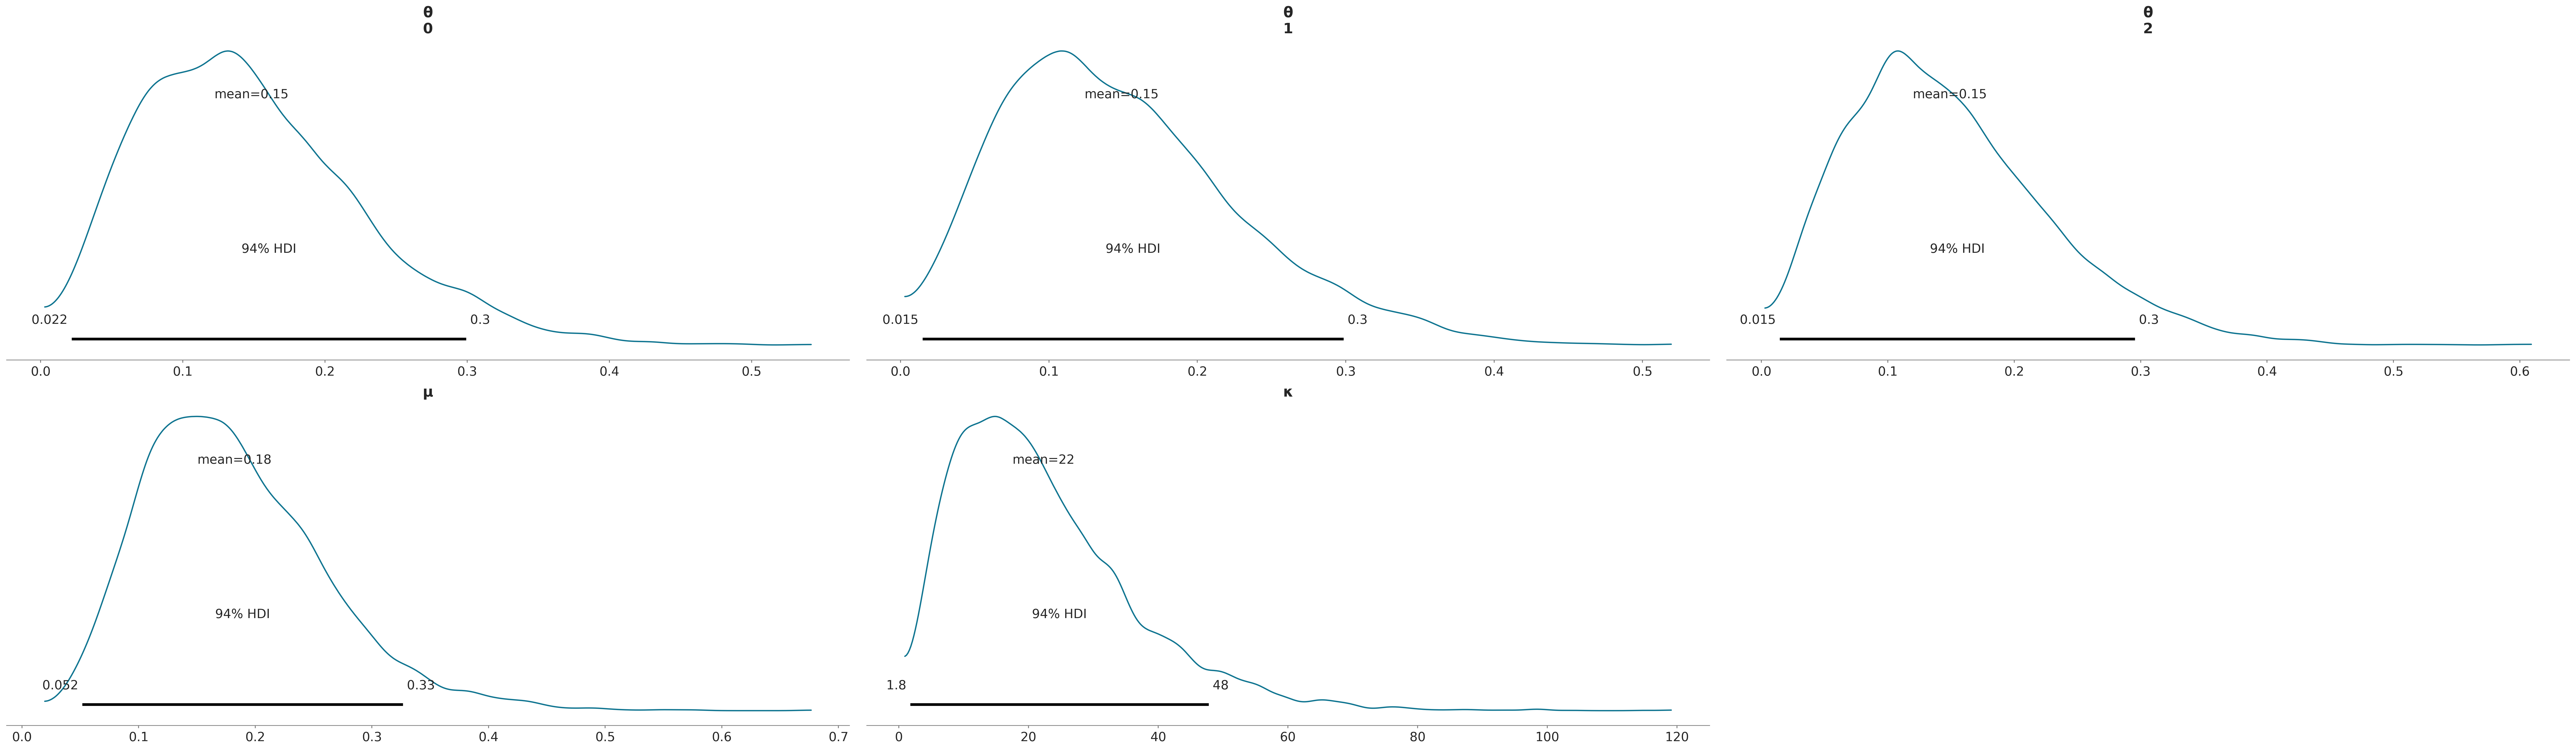

In [14]:
az.plot_posterior(idata_j, var_names=["θ", "μ", "κ"]);

## Ejercicios

1. En el modelo `cs_h` ¿Cuál de los siguientes priors generará mayor *contracción* μ = Normal(0, 0.5) o μ = Normal(0, 1). Justificar

2. Convierte el modelo de las propinas del notebook anterior en un modelo jerárquico (agrupando los días de la semana).

3. Repetir el ejemplo de las monedas jerárquicas, esta vez utilizando los siguientes datos:
    * z = [3,3,3] 
    * z = [18,3,18]

Registar el valor de las medias estimadas para $\theta$, para que puedas comparar los 3 ejemplos (incluyendo `z = [18,18,18]`)